In [1]:
# COMP5339 Week 8 Tutorial
# Material last updated: 29 March 2025
# Note materials were designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Week 8 - Time Series Data

This week's tutorial focusses on **time series data** - a collection of observations obtained through repeated measurements over time. We'll be focussing on a relevant real-world dataset, loading into the database, before exploring how the same information can be represented and queried in two separate ways (point based vs sequence based representations).

## 1. Data Loading

Our dataset for today contains financial trading information - the historical price range of Bitcoin in hourly windows. This has been downloaded from a [CryptoDataDownload](https://www.cryptodatadownload.com/data/gemini) website and is based on the Gemini exchange.

A more in-depth dataset extending back to the start of 2018 is available here as "BitcoinPrices" for those interested in further analysis, but we'll be leveraging the "**BitcoinPricesSubset**" spreadsheet, which only contains data from 2021 onwards, or from July of the earlier years. The code used to generate this subset from the more complete dataset is included as comments in the cell below:

In [2]:
import pandas as pd

# btcfull = pd.read_csv('BitcoinPrices.csv')
# btc = btcfull.copy()
# btc['date'] = pd.to_datetime(btc['unix'],unit='ms')
# btc = btc.loc[(btc['date'].dt.year >= 2021) | (btc['date'].dt.month == 7)]
# btc.drop(columns=['date'], inplace=True)
# btc.to_csv('BitcoinPricesSubset.csv', index=False)

### 1.1 Ingestion

As always, let's first load in the dataset using Pandas (noting this expects the CSV file to be in the same location as this notebook).

In [3]:
btc = pd.read_csv('BitcoinPricesSubset.csv')
btc.head()

,unix,open,high,low,close,volume_btc,volume_usd
0,1651449600000,38481.69,38767.93,38468.60,38706.04,17.916732,6.934858e+05
1,1651446000000,38301.84,38633.76,38251.25,38481.69,24.079628,9.266248e+05
2,1651442400000,38338.69,38564.43,38098.99,38301.84,36.554048,1.400087e+06
3,1651438800000,38310.55,38424.66,38098.15,38338.69,43.560373,1.670048e+06
4,1651435200000,37807.97,38333.33,37687.90,38310.55,13.975364,5.354039e+05


While one would certainly expect a 'date' column to indicate the time period each row concerns, the dataset does not contain an explicit datetime field. Rather, this information is stored in [Unix time](https://en.wikipedia.org/wiki/Unix_time), i.e. the number of seconds or milliseconds that have passed since the 1st of January 1970. All other fields are also numeric.

In [4]:
btc.dtypes

unix            int64
open          float64
high          float64
low           float64
close         float64
volume_btc    float64
volume_usd    float64
dtype: object

Given Unix time is an internationally recognised format, Pandas has the ability to convert this to a datetime field using the `.to_datetime()` function. In this case, the unix information represents the number of milliseconds since 1970, so we'll specify that information in the 'unit' argument.

While there, let's also round the *volume_usd* column to the nearest cent, and drop a couple less relevant columns. This leaves us with one row per hour, with details of the opening and closing price, highest and lowest price, and volume in $US for that time period.

In [5]:
btc['date'] = pd.to_datetime(btc['unix'],unit='ms')
btc['volume_usd'] = round(btc['volume_usd'], 2)
btc.drop(columns=['unix', 'volume_btc'], inplace=True)
btc.head()

,open,high,low,close,volume_usd,date
0,38481.69,38767.93,38468.60,38706.04,693485.75,2022-05-02 00:00:00
1,38301.84,38633.76,38251.25,38481.69,926624.78,2022-05-01 23:00:00
2,38338.69,38564.43,38098.99,38301.84,1400087.29,2022-05-01 22:00:00
3,38310.55,38424.66,38098.15,38338.69,1670047.65,2022-05-01 21:00:00
4,37807.97,38333.33,37687.90,38310.55,535403.89,2022-05-01 20:00:00


### 1.2 Loading

A few familiar heler functions...

In [6]:
import psycopg2
import psycopg2.extras
import json
import os

def pgconnect(credential_filepath):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['dbname']
        try: 
            conn = psycopg2.connect(host=host,
                                database=default_db,
                                user=db_user, 
                                password=db_pw)
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return conn

def pgconnect_ED():
    db_args = {
        'dbname': os.getenv('PGDATABASE'),
        'user': os.getenv('PGUSER'),
        'password': os.getenv('PGPASSWORD'),
        'host': os.getenv('PGHOST'),
        'port': os.getenv('PGPORT', '5432')  # Default to 5432 if not set
    }
    # Create connection with the Postgres database
    try: 
        conn = psycopg2.connect(**db_args)
        print('connected')
    except Exception as e:
            print("unable to connect to the database")
            print(e)
    return conn

def pgexec(conn, sqlcmd, args, msg, silent=False):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if silent == False: 
                print("success: " + msg)
            retval = True
         except Exception as e:
            if silent == False: 
                print("db error: ")
                print(e)
   return retval

def pgquery(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

Create a connection to postgreSQL by calling either `pgconnect` or `pgconnect_ED` (for the former, remember to include your `Credentials.json` file!)

In [7]:
# use the following if run the notebook on your local computer
# conn = pgconnect('Credentials.json')

# use the following if run the note book on ED
conn = pgconnect_ED() 

connected


Let's store this information in a **Prices** schema, within which we'll call the table **Bitcoin**.

In [8]:
schema = """
        create schema if not exists prices;
        set search_path to prices;
        drop table if exists bitcoin;
        """
pgexec(conn, schema, None, "Create Prices Schema")

success: Create Prices Schema


True

We now upload the data to our Bitcoin table. Note this cell may take a minute to run.

In [9]:
create_table = '''
        CREATE TABLE IF NOT EXISTS bitcoin (
            open NUMERIC,
            high NUMERIC,
            low NUMERIC,
            close NUMERIC,
            volume_usd NUMERIC,
            date TIMESTAMP
        )
        '''
pgexec(conn, create_table, None, "Create Table bitcoin")

insert_stmt = '''
        INSERT INTO bitcoin (open, high, low, close, volume_usd, date) VALUES (%s, %s, %s, %s, %s, %s)
        '''
for row in btc.itertuples(index=False, name=None):
    pgexec(conn, insert_stmt, row, True, "One row inserted")
print("All insertions finished!")

print(pgquery(conn, "select count(*) from bitcoin"))
pgquery(conn, "select * from bitcoin limit 10")

success: Create Table bitcoin
All insertions finished!
   count
0  13897


/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)
/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,open,high,low,close,volume_usd,date
0,38481.69,38767.93,38468.60,38706.04,693485.75,2022-05-02 00:00:00
1,38301.84,38633.76,38251.25,38481.69,926624.78,2022-05-01 23:00:00
2,38338.69,38564.43,38098.99,38301.84,1400087.29,2022-05-01 22:00:00
3,38310.55,38424.66,38098.15,38338.69,1670047.65,2022-05-01 21:00:00
4,37807.97,38333.33,37687.90,38310.55,535403.89,2022-05-01 20:00:00
5,37945.29,38072.25,37750.00,37807.97,1091959.69,2022-05-01 19:00:00
6,38370.86,38414.47,37922.46,37945.29,462288.53,2022-05-01 18:00:00
7,38504.53,38601.48,38368.75,38370.86,1464606.81,2022-05-01 17:00:00
8,38511.62,38666.10,38399.14,38504.53,663415.17,2022-05-01 16:00:00
9,37993.92,38649.68,37989.52,38511.62,1526247.52,2022-05-01 15:00:00


## 2. Point Based Representation

A point-based representation involves **multiple rows with atomic data types**. This is a familiar format, given it is how the data has been provided to us - one row per hour, with simple summary statistics of that time frame.

### 2.1 Examples

Examples for this format are less crucial, given our familiarity with building simple queries. For a simple case though, the following query would find the number of hours in the dataset for which the **price varied by at least US$5000**.

In [10]:
sql = """
select count(*)
from Bitcoin
where High-Low >= 5000
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,count
0,9


### 2.2 Tasks

Let's refresh our basic SQL skills by answering the following three questions:

**Task: a)** What is the lowest and highest close price that Bitcoin reached in 2021?

In [11]:
## TO DO
sql = """
select min(close), max(close)
from Bitcoin
where extract(year from date)=2021
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,min,max
0,29078.48,68636.96


**Task: b)** What was the average midnight open price of Bitcoin in April 2022?

*Note: the rounding process may require a conversion to the `numeric` datatype (see the [docs](https://www.postgresql.org/docs/8.1/functions-math.html))*

In [12]:
## TO DO
sql = """
select avg(open)
from Bitcoin
where extract(year from date)=2022 and extract(month from date)=4 and extract(hour from date)=0
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,avg
0,41679.074333


**Task: c)** What was the average hourly volume (in $US) traded in July of each year?

In [13]:
## TO DO
sql = """
select avg(volume_usd), date_trunc('year', date)
from Bitcoin
where extract(month from date)=7
group by date_trunc('year', date)
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,avg,date_trunc
0,8.872870e+05,2018-01-01
1,1.199059e+06,2019-01-01
2,7.791209e+05,2020-01-01
3,2.664659e+06,2021-01-01


## 3. Sequence Based Representation

Now let's pivot to a new storage method for time series data. A sequenced-based representation involves grouping information into a **single row containing an array of time point data**. Take the following example based on a subset of our data:

Point-based:

| date | high | low |
| :--- | :--- | :--- |
| 11-Mar-2022 00:00:00 | 56500.00 | 55500.00 |
| 11-Mar-2022 01:00:00 | 55933.25 | 55139.44 |
| 11-Mar-2022 02:00:00 | 56289.22 | 55664.32 |

Sequence-based:

| date | high | low |
| :--- | :--- | :--- |
| 11-Mar-2022 | [56500.00, 55933.25, 56289.22] | [55500.00, 55139.44, 55664.32] |

### 3.1 Examples

Whenever we seek to create a `group by` query in SQL, all columns must be either in the grouping clause, or an aggregation (e.g. `max`, `avg`, etc). For example, if we wanted to group our data at a daily level rather than an hourly, we could return the average open price, and the total $US amount traded for each day, like below:

In [14]:
sql = """
select date(Date), avg(Open), sum(Volume_USD)
from Bitcoin
group by date(Date)
order by Date
limit 3
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,avg,sum
0,2018-07-01,6349.536667,11673977.42
1,2018-07-02,6448.568333,29969851.54
2,2018-07-03,6601.384167,28387363.36


Rather than produce a *single number* with each aggreggation metric like above, we can return a **complete array** of the relevant values, such as below, where the opening price of each individual hour for that day are bundled up as lists.

In [15]:
sql = """
select date(Date), array_agg(Open order by Date)
from Bitcoin
group by date(Date)
order by Date
limit 3
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,array_agg
0,2018-07-01,"[6389.01, 6370.03, 6359.01, 6339.02, 6350.48, ..."
1,2018-07-02,"[6345.53, 6337.3, 6328.79, 6334.61, 6333.03, 6..."
2,2018-07-03,"[6615.13, 6610.85, 6611.87, 6627.09, 6631.33, ..."


#### How do we build queries with this information format?

To further delve into what's possible with a sequence based format, let's store this example as a subquery/CTE (Common Table Expression) using the `with` clause. This allows us to define a temporary table, here named **Bitcoin2**, from which we can query.

In [16]:
sql = """
with Bitcoin2 as (
  select date(Date), array_agg(Open order by Date) as openPrices
  from Bitcoin
  group by date(Date)
  order by Date
  limit 3
)
select * from Bitcoin2
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,openprices
0,2018-07-01,"[6389.01, 6370.03, 6359.01, 6339.02, 6350.48, ..."
1,2018-07-02,"[6345.53, 6337.3, 6328.79, 6334.61, 6333.03, 6..."
2,2018-07-03,"[6615.13, 6610.85, 6611.87, 6627.09, 6631.33, ..."


When information is stored this way, we can unravel it using the `unnest()` function:

In [17]:
sql = """
with Bitcoin2 as (
  select date(Date), array_agg(Open order by Date) as openPrices
  from Bitcoin
  group by date(Date)
  order by Date
  limit 3
)
select Date, unnest(openPrices) as Open
from Bitcoin2
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,open
0,2018-07-01,6389.01
1,2018-07-01,6370.03
2,2018-07-01,6359.01
3,2018-07-01,6339.02
4,2018-07-01,6350.48
...,...,...
67,2018-07-03,6572.95
68,2018-07-03,6610.06
69,2018-07-03,6619.04
70,2018-07-03,6609.50


Note though that this hasn't fully retained the date information - the column now only contains the date, not the hour. We can ensure the hour is represented with the `generate_series()` function, which effectively includes an index column accordingly.

In [18]:
sql = """
with Bitcoin2 as (
  select date(Date), array_agg(Open order by Date) as openPrices
  from Bitcoin
  group by date(Date)
  order by Date
  limit 3
)
select Date, generate_series(1, 24)-1 as hour, unnest(openPrices) as Open
from Bitcoin2
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,hour,open
0,2018-07-01,0,6389.01
1,2018-07-01,1,6370.03
2,2018-07-01,2,6359.01
3,2018-07-01,3,6339.02
4,2018-07-01,4,6350.48
...,...,...,...
67,2018-07-03,19,6572.95
68,2018-07-03,20,6610.06
69,2018-07-03,21,6619.04
70,2018-07-03,22,6609.50


We can also just extract individual elements from the array, such as the query below, which extracts the first and last open price.

*(Note: this is unfortunately indexed from 1, not 0...)*

In [19]:
sql = """
with Bitcoin2 as (
  select date(Date), array_agg(Open order by Date) as openPrices
  from Bitcoin
  group by date(Date)
  order by Date
  limit 3
)
select Date, openPrices[1] as FirstOpen, openPrices[24] as LastOpen
from Bitcoin2
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,firstopen,lastopen
0,2018-07-01,6389.01,6355.13
1,2018-07-02,6345.53,6621.43
2,2018-07-03,6615.13,6485.81


The `cardinality()` function also allows us to determine how long a given array is:

In [20]:
sql = """
with Bitcoin2 as (
  select date(Date), array_agg(Open order by Date) as openPrices
  from Bitcoin
  group by date(Date)
  order by Date
  limit 3
)
select Date, cardinality(openPrices)
from Bitcoin2
"""
pgquery(conn, sql)

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,cardinality
0,2018-07-01,24
1,2018-07-02,24
2,2018-07-03,24


#### How can we more permanently store this representation?

Rather than rely on a subquery continuously like above, let's create a **Bitcoin2** table to store the Bitcoin price data this way. This can be defined using arrays of a set data type, e.g. `FLOAT[]` indicates an array of floats.

From there, we can insert data based on a simple query that aggregates our information into arrays. Note the importance of a sort - here by Date to ensure it reflects the true hour order.

In [21]:
stmt = """
DROP TABLE IF EXISTS Bitcoin2;
CREATE TABLE IF NOT EXISTS Bitcoin2 (
    Date DATE,
    Open FLOAT[],
    High FLOAT[],
    Low FLOAT[],
    Close FLOAT[],
    Volume_USD FLOAT[]
);

INSERT INTO Bitcoin2 (
    SELECT
        date(Date),
        array_agg(Open ORDER BY Date),
        array_agg(High ORDER BY Date),
        array_agg(Low ORDER BY Date),
        array_agg(Close ORDER BY Date),
        array_agg(Volume_USD ORDER BY Date)
    FROM Bitcoin
    GROUP BY date(Date)
);
"""
pgexec(conn, stmt, None, '')

success: 


True

Investigating the resulting format, we can see a row for each date, with a 24-length array for just about all dates containing the hour-by-hour breakdown of each metric (the 2nd of May has only one value, since there's only information for midnight on that date).

In [22]:
pgquery(conn, "select * from Bitcoin2 order by Date desc limit 3")

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,open,high,low,close,volume_usd
0,2022-05-02,[38481.69],[38767.93],[38468.6],[38706.04],[693485.75]
1,2022-05-01,"[37650.45, 37706.68, 37943.63, 37827.28, 38045...","[37838.04, 38085.61, 38074.73, 38071.82, 38068...","[37505.0, 37412.54, 37765.65, 37816.23, 37903....","[37706.68, 37943.63, 37827.28, 38045.62, 37954...","[1874956.69, 2861442.17, 1542684.2, 790051.0, ..."
2,2022-04-30,"[38582.29, 38638.15, 38700.78, 38701.76, 38659...","[38799.12, 38762.85, 38773.9, 38709.74, 38700....","[38562.3, 38614.8, 38663.21, 38606.09, 38514.9...","[38638.15, 38700.78, 38701.76, 38659.72, 38555...","[563787.35, 455469.04, 495510.53, 496967.22, 2..."


### 3.2 Tasks

From there, let's try and answer the *same* questions from before using this new format. Answer the following questions **using the Bitcoin2 sequence-based representation**, and any relevant functions such as those demonstrated above. For further reading, feel free to consult the [docs on PostgreSQL array functions](https://www.postgresql.org/docs/current/functions-array.html).

**Task: a)** What is the lowest and highest close price that Bitcoin reached in 2021?

In [23]:
## TO DO
sql = """
select min(close), max(close)
from (
    select unnest(close) as close
    from Bitcoin2
    where extract(year from date)=2021
    ) as bitcoin_tmp
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,min,max
0,29078.48,68636.96


**Task: b)** What was the average midnight open price of Bitcoin over April 2022?

In [24]:
## TO DO
sql = """
select avg(open)
from (
    select open[1] as open
    from Bitcoin2
    where extract(year from date)=2022 and extract(month from date)=4
    ) as bitcoin_tmp
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,avg
0,41679.074333


**Task: c)** What was the average hourly volume (in $US) traded in July of each year?

In [25]:
## TO DO
sql = """
select avg(volume_usd), year
from ( select extract(year from date) as year,
        extract(month from date) as month,
        unnest(volume_usd) as volume_usd
        from Bitcoin2
    ) as bitcoin_tmp
where month=7
group by year
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,avg,year
0,8.872870e+05,2018.0
1,1.199059e+06,2019.0
2,2.664659e+06,2021.0
3,7.791209e+05,2020.0


## 4. Inserting New Data

When **new information** is available, how can this be added to our tables, in either representation?

### 4.1 Point Based

The data was provided up until midnight on the 2nd of May. Now that more time has passed since this information was procured, let's test adding the following two new rows of data - one from the next hour that occurred, and the other from the following day (true information from the same source, not simulated):

| date | open | high | low | close | volume_usd |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 02-May-2022 01:00:00 | 38656.76 | 38734.25 | 38492.92 | 38504.47 | 329381.01 |
| 03-May-2022 00:00:00 | 38515.21 | 38562.09 | 38438.30 | 38480.85 | 407549.29 |

For our simple point-based representation, this involves `insert into` statements like so:

In [26]:
pgexec(conn, """
insert into Bitcoin values(38577.47, 38731.47, 38469.48, 38515.21, 1128324.75, '02-May-2022 01:00:00');
insert into Bitcoin values(38515.21, 38562.09, 38438.3, 38480.85, 407549.29, '03-May-2022 00:00:00');
""", None, '')

success: 


True

Returning the five most recent hours confirms the additions were successful:

In [27]:
pgquery(conn, "select * from Bitcoin order by Date desc limit 5")

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,open,high,low,close,volume_usd,date
0,38515.21,38562.09,38438.30,38480.85,407549.29,2022-05-03 00:00:00
1,38577.47,38731.47,38469.48,38515.21,1128324.75,2022-05-02 01:00:00
2,38481.69,38767.93,38468.60,38706.04,693485.75,2022-05-02 00:00:00
3,38301.84,38633.76,38251.25,38481.69,926624.78,2022-05-01 23:00:00
4,38338.69,38564.43,38098.99,38301.84,1400087.29,2022-05-01 22:00:00


### 4.2 Sequence Based

Let's now seek to add the same new rows of information for our sequence based representation:

| date | open | high | low | close | volume_usd |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 02-May-2022 01:00:00 | 38656.76 | 38734.25 | 38492.92 | 38504.47 | 329381.01 |
| 03-May-2022 00:00:00 | 38515.21 | 38562.09 | 38438.30 | 38480.85 | 407549.29 |

This is trickier when seeking to add new values to the lists contained within existing rows. For the 2nd of May entry, we'll need to append it to an existing row, given one hour's worth of data from that day already exists. This is achieved using the `update` statement, specifying we only seek to amend rows concerning that date, and appending the new values to each column using the `array_append()` function.

In [28]:
pgexec(conn, """
update Bitcoin2
set open = array_append(open, 38656.76::float),
    high = array_append(high, 38734.25::float),
    low = array_append(low, 38492.92::float),
    close = array_append(close, 38504.47::float),
    volume_usd = array_append(volume_usd, 329381.01::float)
where date = '2022-05-02'
""", None, '')

success: 


True

For the 3rd of May point though, no current row exists. We can therefore again leverage the `insert into` clause, with our data explicitly stored in arrays.

In [29]:
pgexec(conn, """
insert into Bitcoin2 values(
    '2022-05-03',
    array[38515.21],
    array[38562.09],
    array[38438.30],
    array[38480.85],
    array[407549.29]
)
""", None, '')

success: 


True

Again confirming this is successful:

In [30]:
pgquery(conn, "select * from Bitcoin2 order by Date desc limit 3")

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,date,open,high,low,close,volume_usd
0,2022-05-03,[38515.21],[38562.09],[38438.3],[38480.85],[407549.29]
1,2022-05-02,"[38481.69, 38656.76]","[38767.93, 38734.25]","[38468.6, 38492.92]","[38706.04, 38504.47]","[693485.75, 329381.01]"
2,2022-05-01,"[37650.45, 37706.68, 37943.63, 37827.28, 38045...","[37838.04, 38085.61, 38074.73, 38071.82, 38068...","[37505.0, 37412.54, 37765.65, 37816.23, 37903....","[37706.68, 37943.63, 37827.28, 38045.62, 37954...","[1874956.69, 2861442.17, 1542684.2, 790051.0, ..."


## 5. Visuals

As a final demonstration, let's briefly investigate some potential visualisations that can be built from querying time-series data.

### 5.1 Line Graph

Let's return to the base table, and return an aggregation of **all Open prices for the July months of 2018-2020**.

In [31]:
sql = """
select extract(year from Date) as year, array_agg(open order by Date)
from Bitcoin
where extract(month from Date) = 7 and extract(year from Date) < 2021
group by extract(year from Date)
"""
result = pgquery(conn, sql)
result

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,year,array_agg
0,2018.0,"[6389.01, 6370.03, 6359.01, 6339.02, 6350.48, ..."
1,2019.0,"[10746.0, 11013.04, 10880.65, 11000.0, 11076.9..."
2,2020.0,"[9133.0, 9120.0, 9122.8, 9136.7, 9138.14, 9149..."


From there, we can take this data and visualise each as a line graph for comparison.

*(Note the code line involving a `zip()` function isn't super neat, but necessary to achieve the format matplotlib requires - which is effectively a pivot of how the information is returned. Open to alternative ways people find for this if you're interested!)*

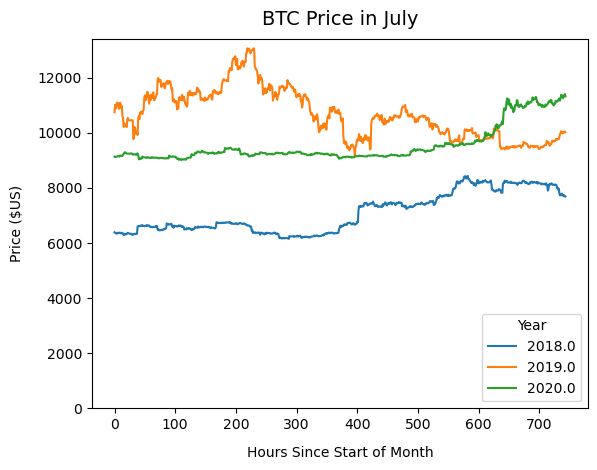

In [32]:
import matplotlib.pyplot as plt
plt.plot(list(zip(*result['array_agg'].tolist())))
plt.legend(result['year'], loc='lower right', title='Year')
plt.title("BTC Price in July", fontdict={'fontsize': 14}, pad=10)  # setting a title
plt.xlabel("Hours Since Start of Month", labelpad=10)  # setting an x-axis
plt.ylabel("Price ($US)", labelpad=10)  # setting a y-axis
plt.ylim(0, )
plt.show()

### 5.2 Histogram

Rather than visualising the changes over the course of a month, we can create visuals to find trends during the day. The below query finds **for each hour of the day, how often the trading price range has exceeded $500 so far this year**.

In [33]:
sql = """
select n, count(*)
from (
  select date, generate_series(1, 24) n, high, low
  from Bitcoin2
) t
where high[n]-low[n] >= 500 and extract(year from date) = 2022
group by n
order by n
"""
result2 = pgquery(conn, sql)
result2

/tmp/ipykernel_103/3626573466.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sqlcmd, conn, params=args)


,n,count
0,1,34
1,2,26
2,3,17
3,4,15
4,5,13
5,6,8
6,7,10
7,8,10
8,9,24
9,10,13


The resulting graph contains some potentially interesting trends for the hours of the day most commonly involving higher trading swings. What could possibly be surmised from this graph?

<BarContainer object of 24 artists>

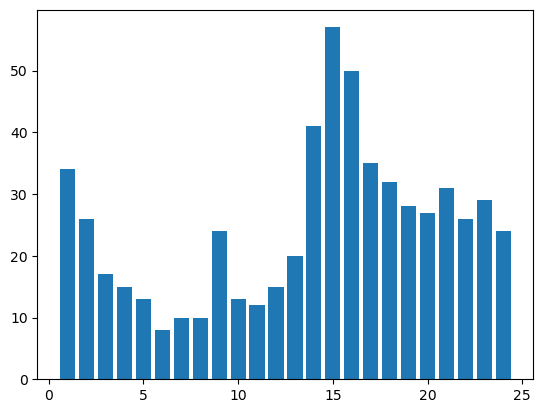

In [34]:
plt.bar(result2['n'], result2['count'])

#### Don't forget to close your connection!

That's all for today's tutorial - enjoy your week! :)

In [35]:
conn.close()